In [44]:
from SocialNetwork.social_network_environment import *
from SocialNetwork.cascade import *
from Advertising.enviroment.bid import *
from Advertising.enviroment.VCG import *
from Advertising.learners.TSLearner import *
from tqdm.autonotebook import tqdm

prev_reward=0
social_network = social_network_environment()
social_network.init_from_json(
    json_path_network='Config/network.json', json_path_features='Config/features.json')
lambdas = [0.8, 0.5, .44, 0.40, 0.35, 0.20]
arms = [0, 1, 2, 3, 4]
vcg = VCG()
random.seed(1234)
# categorie da 1 a 5. Facendo "social_network.categories" ricevi un array di lunghezza 50 (numero dei nodi)
# in cui array[i] == categoria_nodo_i
bids_adversaries = []
for i in range(0, 5):  # numero categorie
    bid_categoria = np.array([])
    for j in range(0, 10):  # numero di avversari
        bid = Bid(bid=random.randint(0, 4), id=j+2)
        bid_categoria = np.append(bid_categoria, bid)
    bids_adversaries.append(bid_categoria)

ts_learner = TS_Learner(n_arms=len(arms), arms=arms, n_categories=5, ad_id=1)

rewards=[]

#definition of the testing code that simulate the auctions
for i in tqdm(range(10000)):
    #add the bid of the learner to our cMPAIN
        pulled_arm=ts_learner.pull_arm()
        for i in range(5):
            bids_adversaries[i][0] = pulled_arm[i] 
        
        best_allocation = vcg.all_best_allocations(list_camp_bids=bids_adversaries, social_network=social_network)
        #ACTIVATE THE CASCADE OF OUR SOCIAL NETWORK AND COMPUTE THE REWARDS
        reward=activate_cascade(social_network=social_network,ad_allocation_list=best_allocation, slot_prominence=lambdas)
        temp=[]
        #with this part of code i set that if the learner is present in the allocation list then get the normal allocation 
        #reward, if it's not present and it bids 0 then the reward is 0.
        #
        for i in range(5):
            control=False
            for j in range(10):
                if (bids_adversaries[i][j].ad_id == 1 & bids_adversaries[i][j].bid!=0 ):
                    control=True              
            if control:
                temp.append(reward[0])
            else:
                temp.append(0)
        #updating of the netwotk           
        ts_learner.update(pulled_arm, temp)
        prev_reward=reward[0]
        rewards.append(reward)


100%|██████████| 10000/10000 [00:20<00:00, 495.46it/s]


In [45]:
#lo stampo solo per vedere qual è il set di bid che viene scelto
for i in bids_adversaries:
    lis=[]
    for j in i:
        lis.append((j.bid, j.ad_id))
    print(lis)    



[(3, 1), (0, 3), (0, 4), (0, 5), (4, 6), (0, 7), (0, 8), (0, 9), (2, 10), (1, 11)]
[(0, 1), (0, 3), (0, 4), (2, 5), (4, 6), (3, 7), (4, 8), (3, 9), (1, 10), (0, 11)]
[(3, 1), (0, 3), (0, 4), (4, 5), (3, 6), (1, 7), (0, 8), (4, 9), (3, 10), (0, 11)]
[(1, 1), (0, 3), (4, 4), (4, 5), (0, 6), (2, 7), (4, 8), (0, 9), (2, 10), (3, 11)]
[(3, 1), (2, 3), (1, 4), (1, 5), (3, 6), (4, 7), (0, 8), (4, 9), (0, 10), (0, 11)]


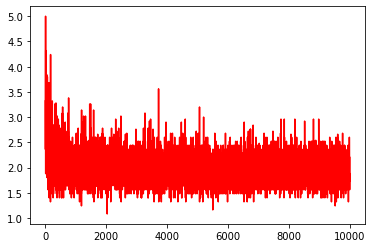

In [46]:
#stampo per vedere com'è il rendimento del learner
#l'ottimo sarebbe che il grafico tende a 0
opt=5
rew_check=np.array([np.mean(ts_learner.collected_rewards[i])for i in range(ts_learner.t)])
plt.figure(0)
plt.plot((opt-rew_check), 'r')
plt.show()
